# Example 5.4  - Accelerated Wear Testing of a Metal Alloy under Varying Applied Weights

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-10-07  
**Version:** 1.1  

---
## Problem Statement

Consider the following example involving a test of a particular metal alloy.  
The sliding test was conducted over a range of different applied weights to study the effect of weight on the wear mechanism.  
The ADT data in terms of weight loss in micrograms are presented in **Table 5.9** and plotted in **Figure 5.14**.  

Assume that a failure occurs when the amount of weight lost exceeds **50 micrograms**.  

Tasks:  
1. Estimate the point estimates of the degradation model parameters, the use-level life if the operational applied weight is given as **5 g**, and the cycle-to-failure distribution at use-level stress using the **LSQ method**.  
2. Repeat this analysis using the **MLE method**, and include the degradation model parameter covariance matrix in the solution (assume no measurement errors).  
3. Repeat the MLE calculation assuming a **10% multiplicative measurement error**.  

Assume the **power model** for damage versus cycles:  

$
D(N, S) = \theta_1 N^{\theta_2},
$

where the parameter $\theta_1$ is a function of applied weight.


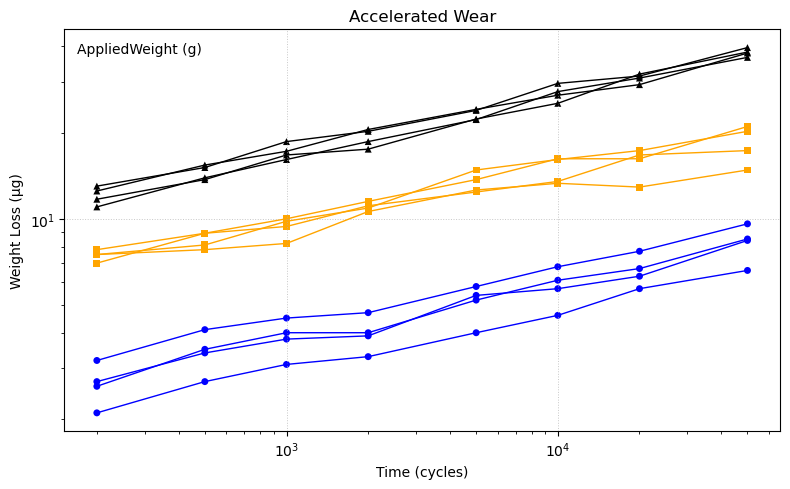

In [2]:
# 0) Load data and basic preprocessing
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import arviz as az
import scipy.stats as st

from scipy.optimize import least_squares, brentq, minimize
from scipy.stats import norm, linregress,weibull_min, gamma, lognorm
from reliability.Fitters import Fit_Everything, Fit_Weibull_2P, Fit_Gamma_2P, Fit_Lognormal_2P


# Load wide-format data
df_wide = pd.read_csv("Example_5.4_test_weight_losses_data.csv")
#df_wide = pd.read_csv("Example_5.4_test_weight_losses_data-Modified.csv") # Modified for more consistent shape parameter fits

# --- Convert wide → long (values are in GRAMS in the CSV) ---
value_cols = [c for c in df_wide.columns if c not in ["AppliedWeight (g)", "Unit"]]
long = df_wide.melt(
    id_vars=["AppliedWeight (g)", "Unit"],
    value_vars=value_cols,
    var_name="Cycles",
    value_name="WeightLoss (µg)"
)

# Ensure numeric dtypes
long["Cycles"] = pd.to_numeric(long["Cycles"], errors="coerce").astype(int)
long["AppliedWeight (g)"] = pd.to_numeric(long["AppliedWeight (g)"], errors="coerce")
long["WeightLoss (µg)"] = pd.to_numeric(long["WeightLoss (µg)"], errors="coerce")

# Failure threshold at 50 micrograms (now in µg to match the y-axis)
Df = 50.0 
# display(long)
# Final arrays (keep names explicit to avoid shadowing)
t_time = long["Cycles"] .to_numpy(float)
T_acc_K = long["AppliedWeight (g)"].to_numpy(float)
D_obs = long["WeightLoss (µg)"] .to_numpy(float)

# --- Plot styling ---
TEMP_COLORS = {10: 'blue', 50: 'orange', 100: 'black'}
TEMP_MARKERS = {10: 'o', 50: 's', 100: '^'}

fig, ax = plt.subplots(figsize=(8, 5))

# Plot by temperature, then by unit (solid lines only)
for weight, gweight in long.sort_values(['AppliedWeight (g)', 'Unit', 'Cycles']).groupby('AppliedWeight (g)'):
    color = TEMP_COLORS.get(weight, 'tab:gray')
    marker = TEMP_MARKERS.get(weight, 'o')

    for unit, gunit in gweight.groupby('Unit'):
        gunit = gunit.sort_values('Cycles')
        ax.plot(gunit['Cycles'].values, gunit['WeightLoss (µg)'].values, label=None, linewidth=1, color=color, linestyle='-')
        ax.scatter(gunit['Cycles'].values, gunit['WeightLoss (µg)'].values, s=25, marker=marker, edgecolors='none', color=color)
        
# Temperature legend (one entry per temperature)
handles = []
labels = []
for t in [83, 133, 173]:
    if (long['AppliedWeight (g)'] == t).any():
        h = ax.plot([], [], color=TEMP_COLORS[t], marker=TEMP_MARKERS[t], linestyle='-', linewidth=1.5)[0]
        handles.append(h)
        labels.append(f'{t} °C')

ax.legend(handles, labels, title='AppliedWeight (g)', frameon=False, ncol=3, loc='upper left')
ax.set_xlabel('Time (cycles)')
ax.set_ylabel('Weight Loss (µg)')
ax.set_title('Accelerated Wear')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.savefig("Example5.4.png",dpi=300)
plt.tight_layout()
plt.show()


In [3]:
# 1) LSQ estimation of physics-informed degradation model
# -----------------------------

W_use = 323.15              # 50 °C in Kelvin
K_eV_perK = 8.617e-5        # Boltzmann const (eV/K)

# Use Kelvin in the exp term
# T_acc_K should be Temperature_C + 273.15 as float

def mu_D(params, t, T_accK, T_use=T_use):
    gamma0, gamma1, Ea = params
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_accK))
    return gamma0 + gamma1 * np.sqrt(t) * accel

def resid(params, t, T_accK, D):
    return D - mu_D(params, t, T_accK)

# Better initial guesses (data-driven defaults)
p0 = [0.1, 1e-5, 0.3]     # γ0 small baseline; γ1 small; a ~ Arrhenius scale

# Bounds consistent with thermal physics and your data scale
bounds = (
    [0.0,   1e-12,   1e-2],   # γ0 ≥ 0; γ1 very small positive; a ≥ 500
    [5.0,   1e5,   10],  # allow modest baseline; wide γ1; realistic a ceiling
)

lsq = least_squares(resid, p0, args=(t_time, T_acc_K, D_obs), bounds=bounds)
gamma0_hat, gamma1_hat, Ea_hat = lsq.x
residuals = lsq.fun
rms = float(np.sqrt(np.mean(residuals**2)))
print(f"LSQ params: gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")
print(f"RMS residual: {rms:.6g}")

D_hat = mu_D(lsq.x, t_time, T_acc_K)


# -----------------------------
# 2.5) LSQ Residual diagnostics visualization
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# a) Residuals vs Fitted
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[0].scatter(D_hat[m], residuals[m], s=15, color=TEMP_COLORS.get(temp_c, "tab:gray"),marker=TEMP_MARKERS.get(temp_c, "o"), 
                    alpha=0.85, label=f"{int(temp_c)} °C")
axes[0].axhline(0, color="k", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted $\\hat{D}$")
axes[0].set_ylabel("Residual (D - $\\hat{D}$)")
axes[0].set_title("Residuals vs Fitted")
axes[0].legend(frameon=False, ncol=3)

# b) Residuals vs Time
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[1].scatter(t_time[m], residuals[m], s=15, color=TEMP_COLORS.get(temp_c, "tab:gray"), marker=TEMP_MARKERS.get(temp_c, "o"), alpha=0.85)
axes[1].axhline(0, color="k", linestyle="--", linewidth=1)
axes[1].set_xlabel("Time (hr)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs Time")

# c) QQ plot
st.probplot(residuals, dist=st.norm, plot=axes[2])
axes[2].set_title("QQ plot of residuals")

plt.tight_layout()
plt.show()


NameError: name 'T_use' is not defined